In [2]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.models import resnet50 
import preprocess.load_split_data as pr
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset,ConcatDataset
sns.set_theme(style="darkgrid")

In [5]:
torch.cuda.is_available()

True

In [31]:
device ="cuda" if torch.cuda.is_available() else "cpu"
# #seed 
# SEED=42
# torch.manual_seed(SEED)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(SEED)

## load data 

In [7]:
# Load MNIST dataset
transform_mnist=transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(),
    # transforms.Normalize((0.1307,), (0.3081,))
])
class_mnist=pr.LoadDataset("MNIST",transform=transform_mnist)
mnist=class_mnist.load_dataset()

In [8]:
mnist

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
            ))

In [9]:
train_mnist,test_mnist=mnist

### Prepare label and unlabel data

In [10]:
# 1% of labeled data
tau=0.01
init_sample=int(tau*len(train_mnist))
indices=torch.randperm(len(train_mnist))

In [11]:
#labeled and unlabeled data indices
labeled_indices=indices[:init_sample]
unlabeled_indices=indices[init_sample:]

In [12]:
label_subset = Subset(train_mnist, labeled_indices)
pool_subset = Subset(train_mnist, unlabeled_indices)

In [13]:
len(label_subset),len(pool_subset)

(600, 59400)

### Dataloader for labeled and unlabeled data

In [14]:
# Setup the batch size hyperparameter
BATCH_SIZE = 64

# Turn datasets into iterables (batches)
train_labeled_dataloader = DataLoader(label_subset, # dataset to turn into iterable
    batch_size=BATCH_SIZE,# how many samples per batch?
    shuffle=True,
)
train_unlabeled_dataloader=DataLoader(pool_subset, # dataset to turn into iterable
    batch_size=BATCH_SIZE,# how many samples per batch?
    shuffle=True,
)
test_dataloader = DataLoader(test_mnist,
    batch_size=BATCH_SIZE,
    shuffle=False
)


### Weak and strong augmentation on unlabeled data

In [24]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.dataset)

In [15]:
# Create a transformation pipeline
weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((20, 20)),
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.GaussianBlur(3),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
])


In [25]:
# Create the datasets with weak and strong augmentation
unlabeled_dataset_weak = TransformDataset(dataset=pool_subset, transform=weak_transform)
unlabeled_dataset_strong = TransformDataset(dataset=pool_subset, transform=strong_transform)

In [62]:
unlabeled_dataset_strong.dataset

In [68]:
# Create the data loaders with weak and strong augmentation directly
unlabeled_dataloader_weak = DataLoader(unlabeled_dataset_weak.dataset, batch_size=BATCH_SIZE)
unlabeled_dataloader_strong = DataLoader(unlabeled_dataset_strong.dataset, batch_size=BATCH_SIZE)


In [69]:
unlabeled_dataloader_weak

### Load model

In [28]:
# Load the pre-trained ResNet50 model without pre-trained weights
model = resnet50(pretrained=False)

/home/nasserali/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nasserali/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Conversion en 3 canaux
model.fc = torch.nn.Linear(2048, 10)  # Modifier la couche de classification pour 10 classes

In [32]:
model.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
# Define the loss function
loss_function = torch.nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

In [35]:
accuracy_dict={}

In [85]:
l=[1,2,3]
s=[4,5,6,7]
r=zip(l,s)

In [89]:
len(train_labeled_dataloader)

10

In [96]:
len(unlabeled_dataloader_weak)

929

In [97]:
len(unlabeled_dataloader_strong)

929

In [101]:
def train_evaluate(model, train_labeled_dataloader, test_dataloader ,unlabeled_dataloader_weak,unlabeled_dataloader_strong ,optimizer, loss_function, epochs,lam=0.9):
    acc_train=[]
    # Train the model
    for epoch in range(epochs):
        for (labeled_images, labels) in train_labeled_dataloader:
            # Get the inputs and labels
            labeled_images, labels = labeled_images.to(device), labels.to(device)
            
            # Forward pass
            outputs_label = model(labeled_images)
        
            # Calculate the loss

            loss_label = loss_function(outputs_label, labels)

            # Backpropagate
            optimizer.zero_grad()
            loss_label.backward()
            optimizer.step()

        for (unlabeled_images_weak),(unlabeled_images_strong) in zip(unlabeled_dataloader_weak,unlabeled_dataloader_strong):

            unlabeled_images_weak=unlabeled_images_weak[0].to(device)
            unlabeled_images_strong=unlabeled_images_strong[0].to(device)

            outputs_weak=model(unlabeled_images_weak)
            outputs_strong=model(unlabeled_images_strong)

            loss_unlabel=loss_function(outputs_weak,outputs_strong)
            # Backpropagate
            optimizer.zero_grad()
            loss_unlabel.backward()
            optimizer.step()



        # Evaluate the model
        with torch.no_grad():
            correct = 0
            total = 0
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            accuracy = correct / total
            acc_train.append(accuracy)

            print(f"Epoch {epoch + 1}: Accuracy {accuracy} for testing" )
    return acc_train

In [102]:
train=train_evaluate(model, train_labeled_dataloader, test_dataloader ,unlabeled_dataloader_weak,unlabeled_dataloader_strong ,optimizer, loss_function, 10)

Epoch 1: Accuracy 0.098 for testing
Epoch 2: Accuracy 0.098 for testing
Epoch 3: Accuracy 0.098 for testing
Epoch 4: Accuracy 0.098 for testing
Epoch 5: Accuracy 0.098 for testing
Epoch 6: Accuracy 0.098 for testing
Epoch 7: Accuracy 0.098 for testing
Epoch 8: Accuracy 0.098 for testing
Epoch 9: Accuracy 0.098 for testing
Epoch 10: Accuracy 0.098 for testing


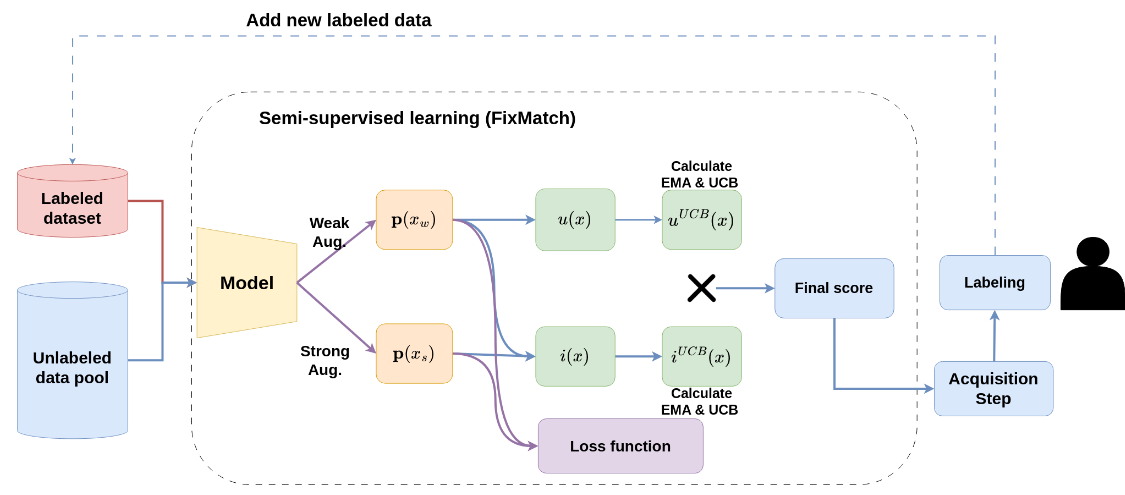